In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
for col in cases:
    if cases[col].dtype == 'float64':
        cases[col] = cases[col].fillna(0)
    if cases[col].dtype == 'O':
        cases[col]= cases[col].fillna("")
vaccinations
for col in vaccinations:
    if vaccinations[col].dtype == 'float64':
        vaccinations[col]=vaccinations[col].astype(object).fillna(0)
    if vaccinations[col].dtype == 'O':
        vaccinations[col]=vaccinations[col].astype(object).fillna("")
vaccinations

,FIPS,Province_State,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated
0,1.0,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",0.0,0.0
1,1.0,Alabama,US,2020-12-11,32.3182,-86.9023,"Alabama, US",0.0,0.0
2,1.0,Alabama,US,2020-12-12,32.3182,-86.9023,"Alabama, US",0.0,0.0
3,1.0,Alabama,US,2020-12-13,32.3182,-86.9023,"Alabama, US",0.0,0.0
4,1.0,Alabama,US,2020-12-14,32.3182,-86.9023,"Alabama, US",0.0,0.0
...,...,...,...,...,...,...,...,...,...
17746,56.0,Wyoming,US,2021-09-22,42.7560,-107.3025,"Wyoming, US",236785.0,40039.0
17747,56.0,Wyoming,US,2021-09-23,42.7560,-107.3025,"Wyoming, US",237374.0,40011.0
17748,56.0,Wyoming,US,2021-09-24,42.7560,-107.3025,"Wyoming, US",237495.0,40023.0
17749,56.0,Wyoming,US,2021-09-25,42.7560,-107.3025,"Wyoming, US",238024.0,40002.0


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
counties['FIPS'] = counties['STATE']*1000 + counties['COUNTY']
counties

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,1000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,1001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,1003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,1005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45189,44996,44780,44319,43663,43188,42917,42717,42673,56037
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,22335,22801,23083,23255,23383,23261,23385,23453,23497,56039
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,20969,20835,20777,20711,20449,20299,20196,20169,20215,56041
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8417,8277,8282,8180,8013,7886,7824,7756,7760,56043


In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
mask_cop = mask_use.copy()
county_data = mask_use.merge(counties, how='inner', left_on = 'COUNTYFP', right_on= 'FIPS').merge(cases,how='inner', left_on = 'FIPS', right_on ='FIPS')


county_data

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,SUMLEV,REGION,DIVISION,STATE,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21
0,1001,0.053,0.074,0.134,0.295,0.444,50,3,6,1,...,8909,8959,9012,9048,9063,9108,9145,9207,9246,9287
1,1003,0.083,0.059,0.098,0.323,0.436,50,3,6,1,...,33789,33968,34063,34142,34246,34393,34536,34726,34872,34950
2,1005,0.067,0.121,0.120,0.201,0.491,50,3,6,1,...,3142,3166,3184,3197,3207,3225,3243,3260,3282,3295
3,1007,0.020,0.034,0.096,0.278,0.572,50,3,6,1,...,3580,3618,3628,3641,3661,3694,3727,3752,3778,3795
4,1009,0.053,0.114,0.180,0.194,0.459,50,3,6,1,...,8763,8830,8862,8899,8951,8998,9048,9095,9161,9176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56037,0.061,0.295,0.230,0.146,0.268,50,4,8,56,...,5791,5791,5791,5791,5929,5970,6034,6111,6111,6111
3137,56039,0.095,0.157,0.160,0.247,0.340,50,4,8,56,...,4502,4502,4502,4502,4568,4572,4587,4611,4611,4611
3138,56041,0.098,0.278,0.154,0.207,0.264,50,4,8,56,...,3053,3053,3053,3053,3086,3141,3168,3204,3204,3204
3139,56043,0.204,0.155,0.069,0.285,0.287,50,4,8,56,...,1080,1080,1080,1080,1087,1104,1111,1120,1120,1120


In [8]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

In [9]:
county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', '9/12/21']].corr()

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/21
NEVER,1.000000,0.427804,0.322870,0.050347,-0.684537,-0.174157
RARELY,0.427804,1.000000,0.364388,0.144175,-0.728177,-0.189829
SOMETIMES,0.322870,0.364388,1.000000,0.073865,-0.668884,-0.181213
FREQUENTLY,0.050347,0.144175,0.073865,1.000000,-0.517932,-0.137103
ALWAYS,-0.684537,-0.728177,-0.668884,-0.517932,1.000000,0.262421
9/12/21,-0.174157,-0.189829,-0.181213,-0.137103,0.262421,1.000000


<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [10]:
X_q5b = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5b = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state=42)

model_q5b = LinearRegression(fit_intercept=True)
model_q5b.fit(X_q5b_train, y_q5b_train)                                                                     
y_q5b_pred_train, y_q5b_pred_test = model_q5b.predict(X_q5b_train), model_q5b.predict(X_q5b_test)
train_rmse_cases = np.sqrt(np.mean((y_q5b_pred_train - y_q5b_train)**2))
test_rmse_cases = np.sqrt(np.mean((y_q5b_pred_test - y_q5b_test)**2))

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [11]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

The model may be overfitted to create favorable test statistics on the training set. Consequently, it performs more poorly on the testing set, resulting in a higher RMSE.

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [12]:
X_q5d = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5d = county_data['9/12/21'] / county_data['POPESTIMATE2020']
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state=42)

model_q5d = LinearRegression(fit_intercept=True)
model_q5d.fit(X_q5d_train, y_q5d_train)                                                                     
y_q5d_pred_train, y_q5d_pred_test = model_q5d.predict(X_q5d_train), model_q5d.predict(X_q5d_test)
train_rmse_cpc = np.sqrt(np.mean((y_q5d_pred_train - y_q5d_train)**2))
test_rmse_cpc = np.sqrt(np.mean((y_q5d_pred_test - y_q5d_test)**2))

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [13]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

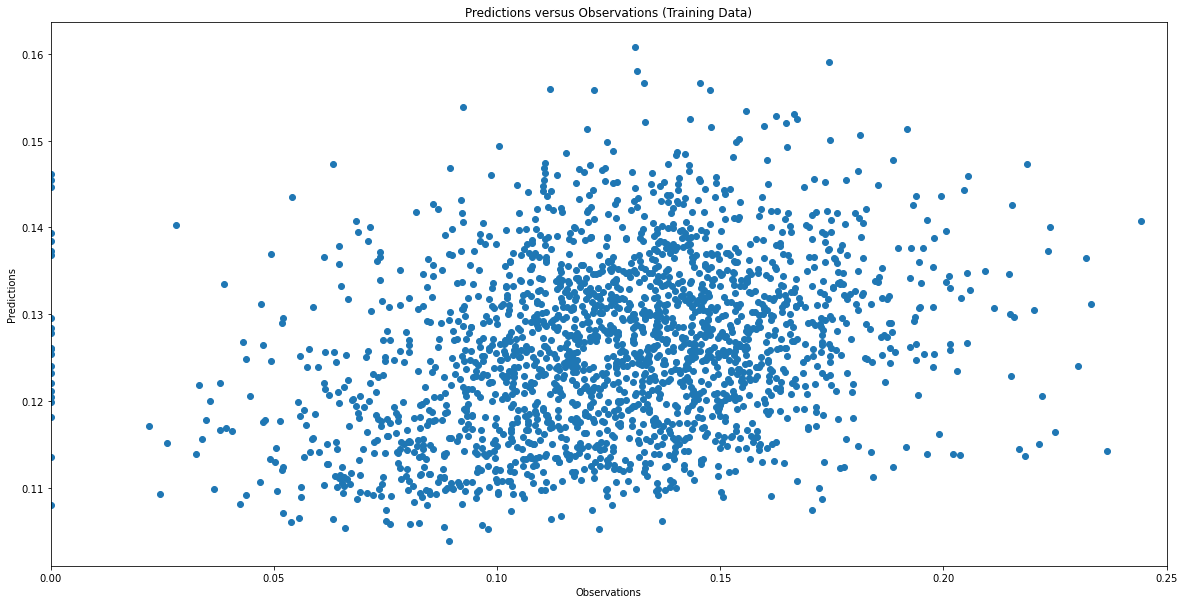

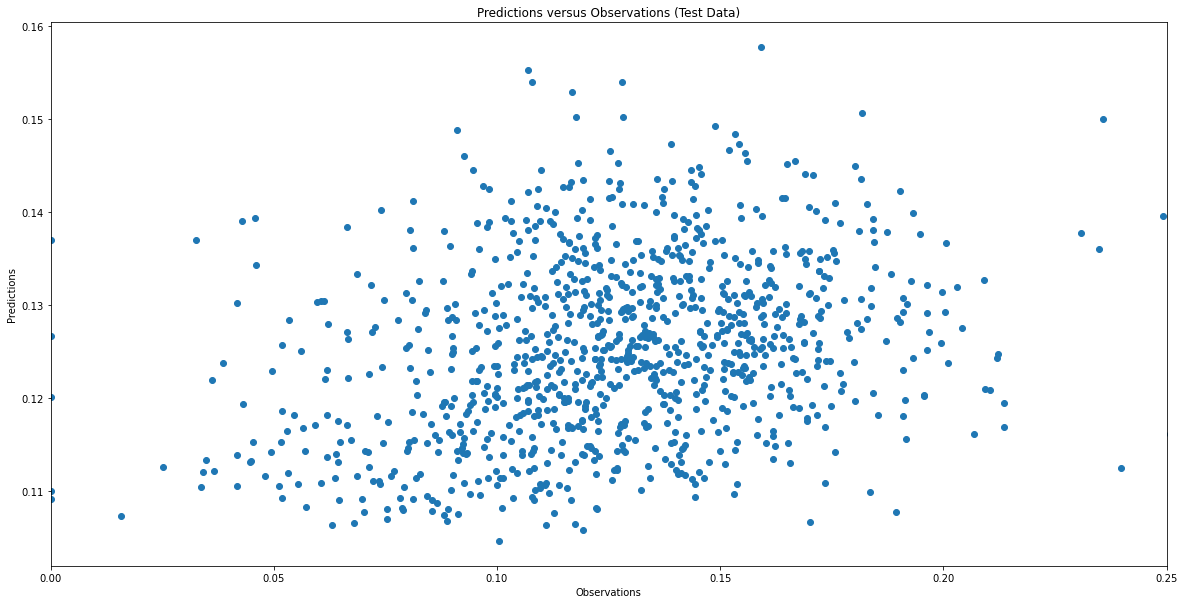

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(x=y_q5d_train, y=model_q5d.predict(X_q5d_train))
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(left=0, right=0.25)
plt.title('Predictions versus Observations (Training Data)')
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(x=y_q5d_test, y=model_q5d.predict(X_q5d_test))
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(left=0, right=0.25)
plt.title('Predictions versus Observations (Test Data)')
plt.show()

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [15]:
X_q5f = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5f = county_data['9/12/21'] / county_data['POPESTIMATE2020']
models = []

for i in np.arange(1000):
    X_q5f_train, X_q5f_test, y_q5f_train, y_q5f_test = train_test_split(X_q5f, y_q5f, test_size=0.33)
    model = LinearRegression(fit_intercept=True).fit(X_q5f_train, y_q5f_train)                  
    models.append(model)

In [16]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [17]:
Xi_5g, yi_5g = X_q5d_test.iloc[[100]], y_q5d_test.iloc[100]

predictions = [x[0] for x in pd.Series(models).apply(lambda x: x.predict(Xi_5g))]

prop_var = np.var(predictions) / np.mean((yi_5g - predictions)**2)

prop_var

0.00046872785520218354

In [18]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

In [19]:
bias = np.sqrt(np.mean((yi_5g - predictions)**2)-np.var(predictions))
bias

0.04029862667205882

i) the bias for this sample point is .04 roughly, so the magnitude is .04. That is assuming no noise and no variance of noise.

ii) Gleaning from the article, we have the glaring problem that the noise, that is the testing methods, how the data is obtained, and other random factors that could obscure our truth function, is actually quite high due to inconsistent testing (not all groups are given tests), delays in testing, or unproportional testing scaling. What's more the noise is not independent, because as we saw in the article rising Covid cases can actually cause testing to be skewed for political reasons as in governments could reduce testing to save face. Also testing can be dependent on X because the counties have different testing protocol.

iii) The conditions for mu should be less than 0 because our testing will always be below the actual true curve, so the noise is always going to be oscillating up and down an underestimation because of the problems with testing listed above. The variance will be more than 0 still.

iv) The bias variance decomposition will not hold the same if noise is normally distributed (-1, 1). I choose negative 1 here arbitrarily but it could be lower. After decomposing the model risk we get bias^2+model variance+2*observed variance(from noise) - 2*model bias. all we need to do to fix it is add and subtract 1 to 𝑦=𝑔(𝑥)+𝜖 to make the middle term cancel out in the original and subtract an additional noise term. So in short, we do 

=E((𝑔(𝑥)+𝜖+1) -(ŷ(x)-1-E(𝜖))^2) 

=E(𝜖^2+2𝜖+1 - 2 * ((𝜖(g(x) - y(x) -1 + 1) + (g(x) -y(x) -1 + 1)) -(E(g(x)-ŷ(x))^2)  --> the E(𝜖) is -1 so the middle term cancels out all terms

=E(𝜖^2+2𝜖+1 -0-E(g(x)-ŷ(x))^2) --> E(𝜖^2+2𝜖+1) is (2 -2 + 1 = 1) because since E(𝜖^2) - -1^2 = 1 E(𝜖^2) must be 2, and 2 * E(𝜖) is -2 based on our dist.

..E(g(x)-ŷ(x))^2) is equal to bias^2 + var as proved in lecture 

= 1 + bias^2 + var. 1 is correct as the first term because it is the observed variance from the noise, so we get 𝜎2+bias^2 + var, as desired.

v) No because our curve is always below the actual given the noise.

vi) as n tends to infinity, if g(x) fits perfectly then the model bias can be 0, as we know the sample mean of the estimator approaches the actual parameter. but in the case of how our noise and the sampling is conducted, even with infinite samples that are conducted with sample error like undercoverage, temporally late, the bias is inherently still there, and the parameter we get even with infinite samples is ultimately biased. 𝑋𝜃≈𝑦 in both the finite and infinite case are always inaccurate by potentially an order of magnitude depending on how bad the samples were conducted.

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [20]:
# all_y is an array of length 1000, with each element being a length 1037 array of predictions for X_q5d_test 
all_y = np.array(pd.Series(models).apply(lambda model: model.predict(X_q5d_test)))
# avg_var is a 1037 length array of the variance for each prediction
avg_var = np.mean(np.var(all_y))
# all_mse is a 1037 length array, with each element being the MSE for that specific yi point
all_mse = [np.mean([(y_q5d_test.iloc[i] - [y[i] for y in all_y])**2]) for i in np.arange(len(y_q5d_test))]
# avg_mse takes the average of all the MSE's
avg_mse = np.mean(all_mse)

avg_var, avg_mse

(1.3455920149156902e-06, 0.0014555280444336388)

In [21]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

MSE may be reduced by adding in more features that are significant when predicting the response variable. However, we must find a good balance between model bias and variance. Even if MSE is 0 for the training data, the model is not helpful if it is simply overfitting the training data and performs poorly on the test data. Noise is inevitable and can only be reduced to a certain extent, so our only hope is to reduce the bias and variance of the model. We have thus far estimated the mean squared error and variance of the model; we can see that the variance is very low compared to the MSE, so the noise and bias must be quite large.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [22]:
gdps = pd.read_csv('data/gdp per county.csv') #getting the gdps per county in terms of personal income from an external data set
#https://apps.bea.gov/regional/downloadzip.cfm → download the CAINC30 Economic Profile by County in the Personal Income bar.
gdps=gdps[gdps['Description']=='Personal income (thousands of dollars)']
gdps

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,"""00000""",United States,,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,13330436000,14003346000,14189228000,14969527000,15681233000,16092713000,16845028000,17681159000,18402004000,19607447000
31,"""01000""",Alabama,5,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,9737715,10628318,...,168474324,173361655,175185262,181078773,189115437,192363456,199336413,207053583,215930375,228748804
62,"""01001""","Autauga, AL",5,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,69973,77712,...,1916140,1968559,1973126,2045307,2158159,2235416,2308229,2384085,2474364,2628375
93,"""01003""","Baldwin, AL",5,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,157191,172745,...,7184451,7375651,7612912,8062553,8629628,9151734,9657577,10228547,10791564,11682821
124,"""01005""","Barbour, AL",5,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,51130,57657,...,768645,761473,807108,799375,832944,820434,824519,847742,877107,930687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99045,"""94000""",Plains,4.0,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,59315639.0,64334104.0,...,878497013.0,927647321.0,939417657.0,979811342.0,1011992470.0,1024102981.0,1055302122.0,1104158972.0,1142093655.0,1213002671.0
99076,"""95000""",Southeast,5.0,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,138939401.0,152550037.0,...,3038507111.0,3173915817.0,3188790838.0,3366606674.0,3539296681.0,3640705117.0,3823894178.0,4012285970.0,4192547392.0,4457671544.0
99107,"""96000""",Southwest,6.0,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,56500512.0,62538485.0,...,1528780998.0,1626388019.0,1671537225.0,1790353193.0,1826323936.0,1826527723.0,1942829427.0,2067960023.0,2159950617.0,2283249340.0
99138,"""97000""",Rocky Mountain,7.0,CAINC30,10.0,...,Personal income (thousands of dollars),Thousands of dollars,17805758.0,19931406.0,...,440397654.0,468046266.0,486655179.0,522936789.0,550866913.0,563546400.0,599075848.0,640642684.0,678596332.0,722806077.0


In [23]:
#adding a feature from outside data set and doing cleaning

gdps = gdps.dropna()
gdps= gdps[gdps['2020'] != "(NA)"]
gdps['GeoFIPS'] = gdps['GeoFIPS'].str.replace('"', "")
gdps['GeoFIPS'] = gdps['GeoFIPS'].astype(int)
gdps['2020'] =pd.to_numeric(gdps['2020'])
gdps = gdps[['GeoFIPS','2020']]
gdps= gdps.groupby('GeoFIPS').agg('sum').reset_index()
gdps = county_data.merge(gdps, how='inner', left_on='COUNTYFP', right_on ='GeoFIPS') 
gdps['2020'] = gdps['2020'] / gdps['POPESTIMATE2020']
gdps
#THE COLUMN 2020 IS THE GDP FOR THAT COUNTY PER CAPITA FOR THE YEAR 2020 IN THOUSANDS OF DOLLARS

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,SUMLEV,REGION,DIVISION,STATE,...,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,GeoFIPS,2020
0,1001,0.053,0.074,0.134,0.295,0.444,50,3,6,1,...,9012,9048,9063,9108,9145,9207,9246,9287,1001,46.814053
1,1003,0.083,0.059,0.098,0.323,0.436,50,3,6,1,...,34063,34142,34246,34393,34536,34726,34872,34950,1003,50.952828
2,1005,0.067,0.121,0.120,0.201,0.491,50,3,6,1,...,3184,3197,3207,3225,3243,3260,3282,3295,1005,37.849730
3,1007,0.020,0.034,0.096,0.278,0.572,50,3,6,1,...,3628,3641,3661,3694,3727,3752,3778,3795,1007,34.300235
4,1009,0.053,0.114,0.180,0.194,0.459,50,3,6,1,...,8862,8899,8951,8998,9048,9095,9161,9176,1009,38.807685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,56037,0.061,0.295,0.230,0.146,0.268,50,4,8,56,...,5791,5791,5929,5970,6034,6111,6111,6111,56037,54.000234
3084,56039,0.095,0.157,0.160,0.247,0.340,50,4,8,56,...,4502,4502,4568,4572,4587,4611,4611,4611,56039,220.644891
3085,56041,0.098,0.278,0.154,0.207,0.264,50,4,8,56,...,3053,3053,3086,3141,3168,3204,3204,3204,56041,42.853821
3086,56043,0.204,0.155,0.069,0.285,0.287,50,4,8,56,...,1080,1080,1087,1104,1111,1120,1120,1120,56043,54.361340


In [24]:
poor = np.round(np.percentile(gdps['2020'], 33.3))
mid_to_upper = np.round(np.percentile(gdps['2020'], 66.7))
poor

43.0

In [25]:
def wealth(x): #a helper function to classify 
    if x <= poor:
        return 'Poor'
    elif (x > poor and x <= mid_to_upper):
        return 'Middle'
    else:
        return 'mid_to_upper'
wealthy = [wealth(i) for i in gdps['2020']]
gdps['class'] = wealthy
gdps['class']

0             Middle
1             Middle
2               Poor
3               Poor
4               Poor
            ...     
3083    mid_to_upper
3084    mid_to_upper
3085            Poor
3086    mid_to_upper
3087          Middle
Name: class, Length: 3088, dtype: object

In [26]:
# Calculate the 33.3 and 66.7 percentile values
q1 = np.percentile(county_data['POPESTIMATE2020'], 33.3)
q2 = np.percentile(county_data['POPESTIMATE2020'], 66.7)

# A dummy helper function to help assign what quantile a county belongs in
def helper(x):
    if x <= q1:
        return 'Small'
    elif (x > q1 and x <= q2):
        return 'Medium'
    else:
        return 'Large'
gdps['size'] = [helper(i) for i in gdps['POPESTIMATE2020']]

In [27]:
gdps['total infections'] = gdps['9/12/21']
gdps['Cases per Capita'] = gdps['total infections']/gdps['POPESTIMATE2020']
gdps = gdps[gdps['POPESTIMATE2020'] <10**5] #remove huge counties
gdps['GDP per capita (in thousands)'] = np.round(gdps['2020'])
gdps = gdps[gdps['GDP per capita (in thousands)'] < 120] #remove outliers


<AxesSubplot:title={'center':'Overlaid Contour plot (prediction) & Scatter plot (Actual) of GDP per capita vs Cases per Capita'}, xlabel='GDP per capita (in thousands)', ylabel='Cases per Capita'>

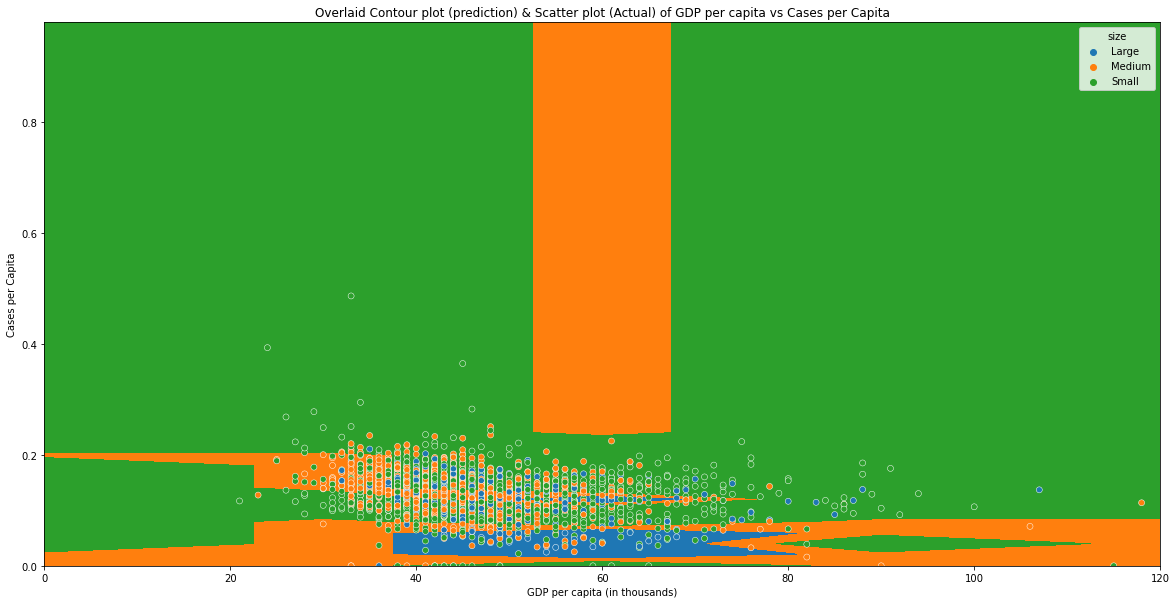

In [28]:
from matplotlib.colors import ListedColormap
from sklearn import ensemble
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])
size_train, size_test = train_test_split(gdps, test_size=0.25, random_state=100)
random_forest_model = ensemble.RandomForestClassifier(n_estimators=20,random_state=42)
random_forest_model = random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
xx, yy = np.meshgrid(np.arange(0,150, 30), np.arange(0, 1, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.figure(figsize=(20,10))
plt.title('Overlaid Contour plot (prediction) & Scatter plot (Actual) of GDP per capita vs Cases per Capita')
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = gdps, x = 'GDP per capita (in thousands)', y = 'Cases per Capita', hue = 'size')

In [29]:
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42) #perform 5 fold cv, show the mean of scores as our accuracy for our classifier
size_train, size_test = train_test_split(gdps, test_size=0.25, random_state=100)
random_forest_model = ensemble.RandomForestClassifier(n_estimators=20,random_state=42)
random_forest_model = random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
cv_scores = cross_val_score(random_forest_model, size_train[['GDP per capita (in thousands)','Cases per Capita']], size_train['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
untuned_ran_forest = np.mean(cv_scores)

Accuracy: 0.410 (0.020)


In [30]:
rf_train_accuracy = random_forest_model.score(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
rf_test_accuracy = random_forest_model.score(size_test[['GDP per capita (in thousands)','Cases per Capita']],size_test['size'])
rf_train_accuracy, rf_test_accuracy

(0.9865879828326181, 0.3987138263665595)

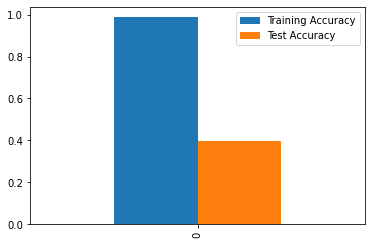

In [31]:
train_accuracy = [ rf_train_accuracy, rf_test_accuracy] # this is our model without any tuning, it is very bad

df = pd.DataFrame([
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'],)
df.plot.bar();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [32]:
"""
The equation for a random forest would follow this 
prediction = rf.predict(test), fitted on random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
We chose these features because we thought a cases per capita and gdp per capita could characterize the size of a county. 
We operated under this assumption
that large counties might have more gdp and have less cases per capita because of increased funding for testing and preventive measures and vice versa
for small counties.
"""


"\nThe equation for a random forest would follow this \nprediction = rf.predict(test), fitted on random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])\nWe chose these features because we thought a cases per capita and gdp per capita could characterize the size of a county. \nWe operated under this assumption\nthat large counties might have more gdp and have less cases per capita because of increased funding for testing and preventive measures and vice versa\nfor small counties.\n"

In [33]:
size_train, size_test = train_test_split(gdps, test_size=0.3, random_state=100)
random_forest_model = ensemble.RandomForestClassifier(n_estimators=100,random_state=42,max_depth=4)
random_forest_model = random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])

In [34]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = cross_val_score(random_forest_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
tuned_ran_forest = np.mean(cv_scores)

Accuracy: 0.474 (0.029)


In [35]:
rf_train_accuracy = random_forest_model.score(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
rf_test_accuracy = random_forest_model.score(size_test[['GDP per capita (in thousands)','Cases per Capita']],size_test['size'])
rf_train_accuracy, rf_test_accuracy

(0.5396551724137931, 0.4785522788203753)

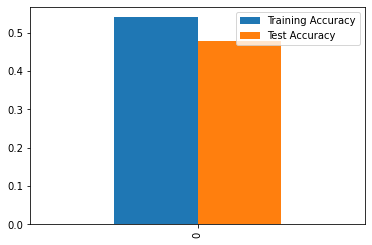

In [36]:
train_accuracy = [ rf_train_accuracy, rf_test_accuracy] #this is our orignal mode's accuracy after tuning the parameters.

df = pd.DataFrame([
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'],)
df.plot.bar();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

The random forest tree must have de-correlated trees, and there is no meaningful prediction function equation here besides the indicator functions that decide the splits.

In [37]:
gdps1=gdps.copy()
def helper1(x): #we will split the counties to just being Small and Big, Small being <= a third of the counties and vice versa for Big counties.
    if x <= q1:
        return 'Small'
    else:
        return 'Big'
gdps1['size'] = [helper1(i) for i in gdps1['POPESTIMATE2020']]

<AxesSubplot:title={'center':'Overlaid Contour plot (prediction) & Scatter plot (Actual) of GDP per capita vs Cases per Capita'}, xlabel='GDP per capita (in thousands)', ylabel='Cases per Capita'>

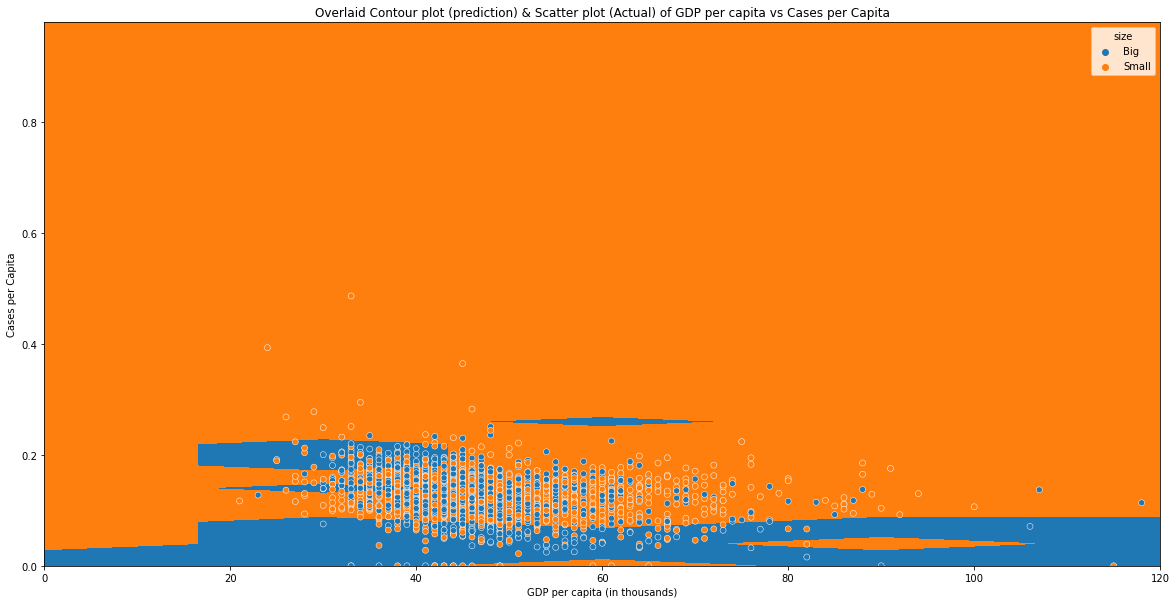

In [38]:
##Since we found that small and medium size counties were different, we will try and predict them here and show accuracy
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:2, :])
size_train, size_test = train_test_split(gdps1, test_size=0.25, random_state=100)
random_forest_model = ensemble.RandomForestClassifier(n_estimators=40,random_state=42)
random_forest_model = random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
xx, yy = np.meshgrid(np.arange(0,150, 30), np.arange(0, 1, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.figure(figsize=(20,10))
plt.title('Overlaid Contour plot (prediction) & Scatter plot (Actual) of GDP per capita vs Cases per Capita')
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = gdps1, x = 'GDP per capita (in thousands)', y = 'Cases per Capita', hue = 'size')

In [39]:
from sklearn.model_selection import cross_val_predict,cross_val_score,RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42) #perform 5 fold cv, show the mean of scores as our accuracy for our classifier
size_train, size_test = train_test_split(gdps1, test_size=0.3, random_state=100)
random_forest_model = ensemble.RandomForestClassifier(n_estimators=100,random_state=42,max_depth = 4)
random_forest_model = random_forest_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
cv_scores = cross_val_score(random_forest_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))


Accuracy: 0.603 (0.025)


In [40]:
rf_train_accuracy = random_forest_model.score(size_train[['GDP per capita (in thousands)','Cases per Capita']],size_train['size'])
rf_test_accuracy = random_forest_model.score(size_test[['GDP per capita (in thousands)','Cases per Capita']],size_test['size'])
rf_train_accuracy, rf_test_accuracy

(0.6752873563218391, 0.6300268096514745)

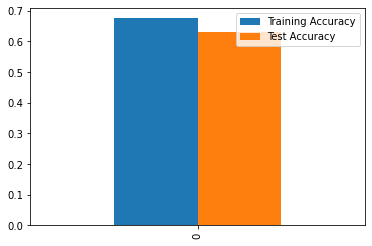

In [41]:
train_accuracy = [ rf_train_accuracy, rf_test_accuracy] #this is our accuracy for our Random Forest model after our 2 major fixes.

df = pd.DataFrame([
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'],)
df.plot.bar();

In [42]:
#here is an overview of tuning different classifier models and seeing how they perform in comparison to random forest.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
size_train, size_test = train_test_split(gdps, test_size=0.25, random_state=100)
decision_tree_model = tree.DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=5)
decision_tree_model = decision_tree_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']], size_train['size'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = cross_val_score(decision_tree_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
tuned_dtree = np.mean(cv_scores)

Accuracy: 0.449 (0.051)


In [44]:
decision_tree_model = tree.DecisionTreeClassifier(criterion='gini',random_state=42)
decision_tree_model = decision_tree_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']], size_train['size'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = cross_val_score(decision_tree_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
untuned_dtree = np.mean(cv_scores)

Accuracy: 0.377 (0.033)


In [45]:
size_train, size_test = train_test_split(gdps, test_size=0.25, random_state=100)
logistic_regression_model = LogisticRegression(multi_class = 'multinomial')
logistic_regression_model=logistic_regression_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']], size_train['size'])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = cross_val_score(logistic_regression_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
tuned_lReg = np.mean(cv_scores)

Accuracy: 0.479 (0.028)


In [46]:
size_train, size_test = train_test_split(gdps, test_size=0.25, random_state=100)
logistic_regression_model = LogisticRegression(multi_class = 'ovr')
logistic_regression_model=logistic_regression_model.fit(size_train[['GDP per capita (in thousands)','Cases per Capita']], size_train['size'])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_scores = cross_val_score(logistic_regression_model, size_test[['GDP per capita (in thousands)','Cases per Capita']], size_test['size'], cv=cv)
print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))
untuned_lReg = np.mean(cv_scores)

Accuracy: 0.477 (0.029)


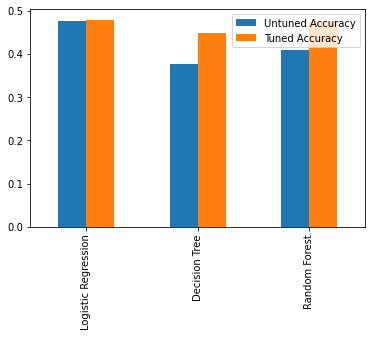

In [47]:
train_accuracy = [untuned_lReg, tuned_lReg, untuned_dtree, tuned_dtree, untuned_ran_forest, tuned_ran_forest] #plot of classifier accuracy w/tuning
index = ['Logistic Regression', 'Decision Tree', 'Random Forest']
df = pd.DataFrame([(untuned_lReg, tuned_lReg), 
                   (untuned_dtree, tuned_dtree),
                   (untuned_ran_forest, tuned_ran_forest)], 
                  columns=['Untuned Accuracy', 'Tuned Accuracy'], index=index)
df.plot.bar();

In [48]:
#the following is some data cleaning and simulation for A/B testing

In [49]:
ranFor_data = county_data.copy()
c_data = pd.DataFrame({'9/12/21' : ranFor_data['9/12/21']}) # get cases per county up to the most recent date
c_data['CTYNAME'] = county_data['CTYNAME']

c_data['POPESTIMATE2020']=county_data['POPESTIMATE2020']
y_data = c_data.groupby(['CTYNAME']).agg('sum') #obtain the total amount of infections for each county


y_data['total infections'] = y_data['9/12/21']
y_data = y_data.reset_index()
y_data['size'] = size_labels = [helper(i) for i in y_data['POPESTIMATE2020']] #create size labels
y_data['Cases per Capita'] = y_data['total infections']/y_data['POPESTIMATE2020']
y_data['size'] = size_labels

y_data = y_data[y_data['POPESTIMATE2020'] <10**5] #remove outliers

y_data = y_data[['CTYNAME','POPESTIMATE2020','total infections','size','Cases per Capita']]
y_data

,CTYNAME,POPESTIMATE2020,total infections,size,Cases per Capita
0,Abbeville County,24404,3208,Medium,0.131454
1,Acadia Parish,61918,9885,Large,0.159647
2,Accomack County,32238,3474,Medium,0.107761
4,Adair County,73968,11227,Large,0.151782
6,Addison County,36851,1281,Medium,0.034762
...,...,...,...,...,...
1870,Yuba County,80160,8865,Large,0.110591
1871,Yukon-Koyukuk Census Area,5077,478,Small,0.094150
1873,Zapata County,14172,2119,Small,0.149520
1874,Zavala County,11840,2316,Small,0.195608


<AxesSubplot:title={'center':'Cases per Capita'}, xlabel='[size]'>

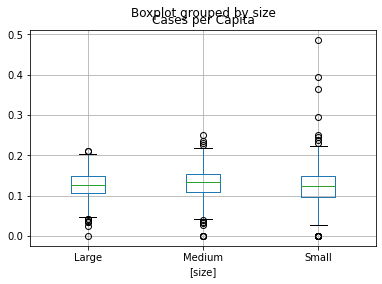

In [50]:
boxplot1 = y_data[['size','Cases per Capita']]
boxplot1.boxplot(column=['Cases per Capita'], by=['size'])

In [51]:
#we will perform 3C2 , basically 3, AB tests for each combination to see a difference between populations. 

def test_statistic(col1,col2,t):
    tbl = t.copy()
    tbl = tbl.groupby('size').agg('mean').reset_index()
    return (tbl[tbl['size']==col1]['Cases per Capita'].iloc[0]-tbl[tbl['size']==col2]['Cases per Capita'].iloc[0]  ) #abs value of the means of 2 groups
o_large_small = test_statistic('Large','Small',boxplot1)
o_large_med = test_statistic('Medium','Large',boxplot1)
o_med_small = test_statistic('Medium','Small',boxplot1) #observed statistics

def simulate_null(col1,col2,boxplot1):
    shuffled = np.random.permutation(boxplot1['Cases per Capita']) #shuffle the cases per capita
    newTab = boxplot1.copy()
    newTab["Cases per Capita"] = shuffled
    return test_statistic(col1,col2,newTab) #get the diff of means of the 2 groups


In [52]:
large_small_test = []
large_med_test = []
med_small_test = []
for i in np.arange(0,500):
    stat = simulate_null('Large','Small',boxplot1)
    large_small_test = np.append(large_small_test,stat)
for i in np.arange(0,500):
    stat = simulate_null('Large','Medium',boxplot1)
    large_med_test  = np.append(large_med_test,stat)
for i in np.arange(0,5000):
    stat = simulate_null('Medium','Small',boxplot1)
    med_small_test = np.append(med_small_test,stat)

In [53]:
#p values
large_small_p = np.count_nonzero(large_small_test>= o_large_small)/500 #count how many differences are smaller than observed, if 
large_medium_p = np.count_nonzero(large_med_test>= o_large_med)/500
med_small_p = np.count_nonzero(med_small_test>= o_med_small)/5000

In [54]:
large_small_p

0.198

In [55]:
large_medium_p

0.058

In [56]:
med_small_p

0.0026

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [57]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [58]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [59]:
...

Ellipsis

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [60]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [61]:
# Save your notebook first, then run this cell to export your submission.
grader.export()